In [1]:
import pickle

with open('trainX.pkl', 'rb') as f:
    trainX = pickle.load(f)

with open('testX.pkl', 'rb') as f:
    testX = pickle.load(f)

with open('trainY.pkl', 'rb') as f:
    trainY = pickle.load(f)

with open('testY.pkl', 'rb') as f:
    testY = pickle.load(f)

with open('valX.pkl', 'rb') as f:
    valX = pickle.load(f)

with open('valY.pkl', 'rb') as f:
    valY = pickle.load(f)

with open('le.pkl', 'rb') as f:
    le = pickle.load(f)


In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D,Input
from tensorflow.keras.layers import Activation, Dropout,BatchNormalization, Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
s=150
batch_size = 40
epochs = 20

In [4]:
model_base = InceptionV3(input_shape = (s, s, 3), include_top = False)

In [5]:
x = Flatten()(model_base.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='sigmoid')(x)
model = keras.models.Model(model_base.input, x)
model.compile(optimizer = keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

In [6]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',
    min_delta = 0,
    patience = 3,
    verbose = 1,
    restore_best_weights = True
)

In [7]:
aug = ImageDataGenerator(rotation_range=0, zoom_range=0.0,width_shift_range=0.2, 
                         height_shift_range=0.2, shear_range=0.15,
                         horizontal_flip=True, fill_mode="nearest")

In [8]:
inc_history = model.fit(aug.flow(trainX, trainY, batch_size=batch_size),
                     epochs=epochs,
                     callbacks = [early_stopping],
                     validation_data = (valX,valY),
                     verbose=1
)

Epoch 1/20
339/339 [==============================] - 89s 194ms/step - loss: 0.2486 - acc: 0.8161 - val_loss: 0.2470 - val_acc: 0.8964
Epoch 2/20
339/339 [==============================] - 61s 179ms/step - loss: 0.1469 - acc: 0.9006 - val_loss: 0.4360 - val_acc: 0.8471
Epoch 3/20
339/339 [==============================] - 61s 180ms/step - loss: 0.1205 - acc: 0.9177 - val_loss: 0.3502 - val_acc: 0.9188
Epoch 4/20
339/339 [==============================] - 61s 181ms/step - loss: 0.1138 - acc: 0.9235 - val_loss: 0.8359 - val_acc: 0.8438
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping


In [9]:
modelLoss, modelAccuracy = model.evaluate(aug.flow(testX, testY))
print('Test Loss is {}'.format(modelLoss))
print('Test Accuracy is {}'.format(modelAccuracy ))



133/133 [==============================] - 13s 95ms/step - loss: 0.2870 - acc: 0.8800
Test Loss is 0.2870464622974396
Test Accuracy is 0.8799905776977539


In [10]:
# modelLoss, modelAccuracy = model.evaluate(aug.flow(trainX, trainY))

# print('Test Loss is {}'.format(modelLoss))
# print('Test Accuracy is {}'.format(modelAccuracy ))


In [11]:
# # classification report on train
# predIdxs = model.predict(aug.flow(trainX), batch_size=batch_size)
# predIdxs = np.argmax(predIdxs, axis=1)
# print(classification_report(trainY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

In [12]:
# classification report on test

predIdxs = model.predict(testX, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

              precision    recall  f1-score   support

    Covid-19    0.18421   0.13555   0.15618       723
Lung Opacity    0.26910   0.26373   0.26639      1202
      Normal    0.48320   0.53605   0.50825      2039
   Pneumonia    0.04598   0.04461   0.04528       269

    accuracy                        0.35908      4233
   macro avg    0.24562   0.24498   0.24402      4233
weighted avg    0.34355   0.35908   0.35002      4233



In [13]:
class_names = ['Covid-19', 'Lung Opacity', 'Normal', 'Pneumonia']
y_pred = model.predict(testX)
print(class_names[np.argmax(y_pred[11])])

Normal


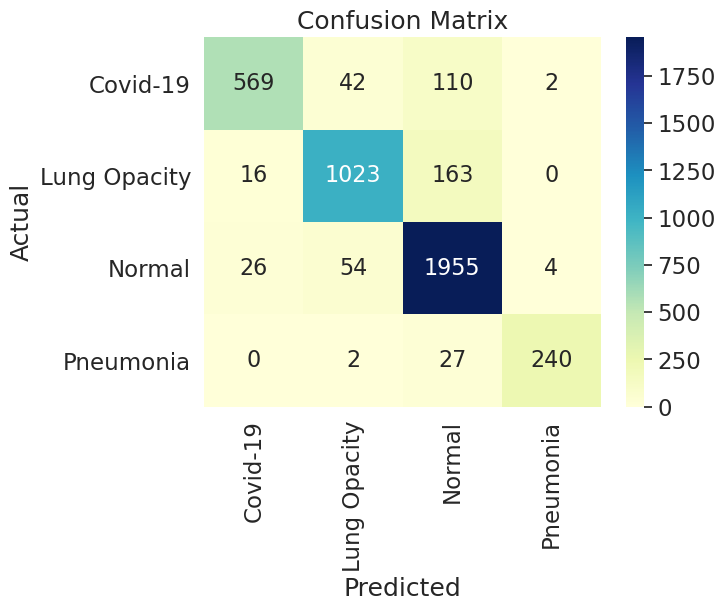

In [14]:
# Plotting Confusion Matrix
x = confusion_matrix(testY.argmax(axis=1),y_pred.argmax(axis=1))
Confusion_Matrix = pd.DataFrame(x,index=class_names, columns=class_names)

sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(Confusion_Matrix, annot=True, annot_kws={'size':16}, fmt='d', cmap='YlGnBu')

plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title('Confusion Matrix')
plt.show()

In [15]:
plt.plot(inc_history.history['acc'], label='accuracy')
plt.plot(inc_history.history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend(loc='center right')


In [16]:
model.save('inc_history_model.h5') 